In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.utils import load_img, img_to_array
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

Introduction
This project is part of the second year curriculum for EGES, SISCO and SISY. It is recommended
that the project be done in pairs, and each pair must submit its own work. Duplication of work by
different pairs is not permitted.
Each pair must submit their work in the form of a report of about 10 to 15 pages maximum, as well
as the source code of the work in the form of Python files or a Jupyter notebook. The work must be
submitted by 28/05/2023 at the latest on the Google Classroom platform dedicated to this purpose.
Project topic
The project consists in recognizing, from an image, the people who appear in it and analyzing the
facial expression of each of them. Eight facial expressions are generally considered, namely:
1. Anger
2. Contempt
3. Disgust
4. Fear
5. Happiness
6. Sadness
7. Surprise
8. Neutral

In this work, you should recognize at least three of them. If some of the people in the image are not
recognized, your solution should at least recognize the facial expression. The result should be
expressed by a sentence, e.g. "Foulen is Sad", if the person was recognized or, "An unknown person
in the image is happy" in the opposite case.
Since the images may contain several people, it is important to be able to detect the faces. Several
techniques are possible including the use of Cascade Classifier from OpenCV. The latter allows not
only to frame a face or an object with a bouding box but can even extract it as an independent
image.

Requested work
1. Build or find a dataset for both facial recognition and facial expression classification. The
two datasets are not especially the same.
2. Build your model for recognizing people and their facial expressions.
3. Submit a report that explains your work and the choices you made to solve the problem.
4. Provide the source code of your solution.

In [2]:
classes= ["angry","disgust","fear","happy","neutral","sad","surprise"]
picture_size = 48
folder_path = "C:/Users/lenovo/Desktop/data science project/"

In [ ]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
    
plt.show()


In [ ]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)


# Model Architecture

Our model is based on the use of 4 CNN layers including the batchnormalization and the dropout, and then a flatten layer and we finish our model with two fully connected layer

In [ ]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model

After selecting our model, the training process becomes a crucial step. It is a common challenge in machine learning models, especially CNN models, to find the appropriate parameters that lead to quick convergence and prevent overfitting. To address this, we will employ callbacks to effectively manage the training process.

We will incorporate the following callbacks which make us effectively control and optimize the training process of our CNN model, mitigating the risk of overfitting and facilitating swift convergence towards optimal performance.

EarlyStopping: This callback halts the training of the model if there is no improvement in performance after a specified number of epochs, which in our case is set to 10 epochs. Its purpose is to prevent overfitting by stopping further training when performance plateaus.

ReduceLROnPlateau: This callback dynamically adjusts the learning rate based on the model's performance. Initially, we will start with a relatively high learning rate, and if no improvement is observed after 5 iterations, the learning rate will be reduced. This mechanism ensures that the model converges efficiently and rapidly.

ModelCheckpoint:  Serves as a powerful tool for saving the best model during the training process based on a specified criterion. It allows you to monitor the model's performance and save the weights of the model at certain checkpoints.



In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')



reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True)


callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs =50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

In [ ]:
model.save('mon_model.h5')

In [ ]:

plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.evaluate(test_set)


The model performs as follows:

Training accuracy: 67%

Validation accuracy: 36%

We'll see how we can improve our model.

# Amelioration of the model using data augmentation 

Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.  

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed data for each category
train_generator = train_datagen.flow_from_directory(
    folder_path+"train",
    target_size=(48, 48),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_gen.flow_from_directory(
    folder_path+"test",
    target_size=(48, 48),
    color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

In [ ]:
rows = 5
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))

for i in range(rows):
    for j in range(columns):
        image = train_generator[i][0][j]   
        axs[i, j].imshow(image)
        axs[i, j].axis('off')  
        
plt.tight_layout()  
plt.show() 

In [ ]:
history1 = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = val_generator,
                                validation_steps = val_generator.n//val_generator.batch_size,
                                callbacks=callbacks_list
                                )

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


As anticipated, the process of training the model becomes challenging. While data augmentation often enhances model performance, in our specific scenario, the data contains noticeable noise, which restricts substantial improvements in the model. Despite applying data augmentation techniques, the introduced variations in the data are insufficient to effectively eliminate the noise. As a result, the impact on the model's performance remains moderate. This emphasizes the significance of considering data quality when implementing data augmentation, as it plays a crucial role in determining the effectiveness of these techniques.

# Face detection 

In [12]:
def face_recog(img):
    #we need a face detection algorithm (gray image)
    faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color= img[y:y+h, x:x+w]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        faces=faceCascade.detectMultiScale(roi_gray)
        if len(faces)==0:
            print("face not detected")
        else:
            for(ex,ey,ew,eh)in faces:
                face_roi=roi_color[ey:ey+eh,ex:ex+ew]
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    
    gray_image = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray_image)
    return gray_image
def emotion(pred):
    return classes[pred]

In [ ]:
def face_recog1(img):
    #we need a face detection algorithm (gray image)
    faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color= img[y:y+h, x:x+w]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        faces=faceCascade.detectMultiScale(roi_gray)
        if len(faces)==0:
            print("face not detected")
        else:
            for(ex,ey,ew,eh)in faces:
                face_roi=roi_color[ey:ey+eh,ex:ex+ew]
    #plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    
    gray_image = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)
    return gray_image

Exemple :

(192, 192)

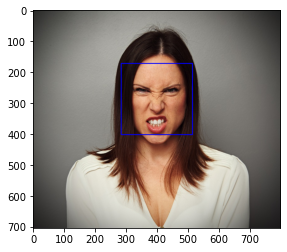

In [39]:
expl=cv2.imread(r"C:\Users\lenovo\Desktop\data science project\disgust.jpg")
image=face_recog(expl)
image.shape

In [ ]:
gray_image=cv2.resize(image,(48,48))
final_image = np.reshape(gray_image, (1, 48, 48, 1))
#final_image=np.expand_dims(final_image,axis=2) #we add a fourth dim
final_image=final_image/255.0 #normalizing
final_image.shape


In [ ]:
pred=model.predict(final_image)
n=np.argmax(pred)
emotion(n)

# Facial recognition 

for the face recognition we will work on another data set from kaggel named "105_classes_pins_dataset".

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

directory = 'C:/Users/lenovo/Desktop/data science project/105_classes_pins_dataset'

Name=[]
for file in os.listdir(directory):
    Name+=[file[5:]]
print(Name)
print(len(Name))

['Cristiano Ronaldo', 'Emilia Clarke', 'Johnny Depp', 'Lionel Messi', 'Mark Zuckerberg', 'Megan Fox']
6


In [4]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))

dataset=[]
testset=[]
count=0
for file in os.listdir(directory):
    path=os.path.join(directory,file)
    t=0
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(120,120))
        image=img_to_array(image)
        image=image/255.0
        t+=1
        if t<=100:
            dataset.append([image,count])
        else:
            testset.append([image,count])
    count+=1

In [5]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)


labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)


tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)


trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)


print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(463, 120, 120, 3)
(116, 120, 120, 3)
(463, 6)
(116, 6)


Generating our data 


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

downloading the architectur of the chosen model DenseNet201

In [ ]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(120,120,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

Changing the input and the output to be adaptable with our case

In [ ]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model1 = tf.keras.Model(inputs=inputs3, outputs=outputs3)

# Model training

In [ ]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hist = model1.fit(datagen.flow(trainx, trainy, batch_size=32),
                    validation_data=(testx, testy),
                    epochs=30,
                    callbacks=callbacks_list)

In [ ]:
model1.save("my_model.h5")
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

The model of face recognition performs as follow:

Training accuracy: 84%

Validation accuracy: 81%

This is a perfect result.

In [ ]:

y_pred=model1.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

Exemple :

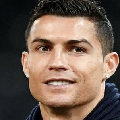

In [16]:
image=load_img(r"C:/Users/lenovo/Desktop/data science project/105_classes_pins_dataset/pins_Cristiano Ronaldo/Cristiano Ronaldo75_1363.jpg",target_size=(120,120))
image

In [17]:
image=img_to_array(image)
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

def mapper(value):
    return reverse_mapping[value]

prediction=model1.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

1/1 [==============================] - 0s 115ms/step
Prediction is Cristiano Ronaldo.


# Models combination

In [18]:
from tensorflow.keras.models import load_model
model = load_model("mon_model.h5")
model1 = load_model("my_model.h5")
def resultat(im_path):

    # Load the image
    A = cv2.imread(im_path)
    if A is None:
        print("Impossible de charger l'image.")
        exit()
    #plt.imshow(cv2.cvtColor(A,cv2.COLOR_BGR2RGB))
    
    g=face_recog(A)
    g_image=cv2.resize(g,(48,48))
    final = np.reshape(g_image, (1, 48, 48, 1))
    #final_image=np.expand_dims(final_image,axis=2) #we add a fourth dim
    final=final/255.0 #normalizing
    pred=model.predict(final)
    n=np.argmax(pred)
    
    
    img=load_img(im_path,target_size=(120,120))
    image=img_to_array(img)
    image=image/255.0
    prediction_image=np.array(image)
    prediction_image= np.expand_dims(image, axis=0)
    prediction=model1.predict(prediction_image)
    value=np.argmax(prediction)
    move_name=mapper(value)
    if prediction.max() > 0.75:
        person = move_name
    else:
        person = "Unknown"
    #print(prediction)
    #print(value)
    
    print("this picture shows",person , "and he is" , emotion(n))
    

face not detected
1/1 [==============================] - 0s 151ms/step
this picture shows Lionel Messi and he is happy


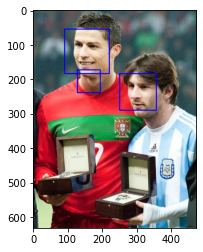

In [20]:
resultat(r"C:/Users/lenovo/Desktop/data science project/OIP.jpg")